<h3><center>Predicting Stroke Risk</center></h3>   

    
<center>Sam Loyd</center>
<center>June 2021</center> 

In [1]:
# Required Modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import *
from imblearn.combine import SMOTETomek
from collections import Counter
from pycaret.classification import *
from sklearn import metrics
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import StandardScaler

## Data Analysis - EDA

In [2]:
# Pull in data for stroke data 
stroke_df = pd.read_csv("data\\healthcare-dataset-stroke-data.csv")

In [3]:
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [4]:
# Correct data types
stroke_df['stroke'] = stroke_df['stroke'].astype(bool)
stroke_df['hypertension'] = stroke_df['hypertension'].astype(bool)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(bool)

In [5]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
2,31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
3,60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True
4,1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,True


In [6]:
# Apply profie and create html report
# Commented out for performance
# prof = ProfileReport(stroke_df,title="Pandas Profiling Report - Stroke Data", explorative=True)
# prof.to_file(output_file='stroke-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

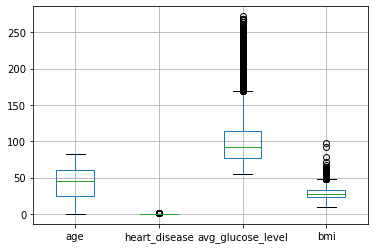

In [7]:
# Pandas-profiling is lacking in outlier analysis visuals so those are included here.

# Box and whisker plots for outlier analysis.
boxplot = stroke_df.boxplot(column=['age', 'heart_disease', 'avg_glucose_level','bmi'])

While outliers were discovered, they were within acceptable ranges according to domain knowledge.
They will not be removed.

## Data Wrangling  
Impute missing values found in the EDA process using pandas-profile report.

In [8]:
# Count nulls
stroke_df.bmi.isnull().sum()

201

In [9]:
# Take a deeper look at these
stroke_null = stroke_df[stroke_df.bmi.isnull()]

In [10]:
# View 
stroke_null.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
8,27419,Female,59.0,False,False,Yes,Private,Rural,76.15,NaN,Unknown,True
13,8213,Male,78.0,False,True,Yes,Private,Urban,219.84,NaN,Unknown,True
19,25226,Male,57.0,False,True,No,Govt_job,Urban,217.08,NaN,Unknown,True
27,61843,Male,58.0,False,False,Yes,Private,Rural,189.84,NaN,Unknown,True


In [11]:
# about 25%
stroke_null.stroke.value_counts()

False    161
True      40
Name: stroke, dtype: int64

In [12]:
# about 5%
stroke_df.stroke.value_counts()

False    4861
True      249
Name: stroke, dtype: int64

That seems too many data points that have had strokes to throw out given that it is already only 5%.  
As in most cases of missingness there are no good options, but in this case, it does the least harm to impute using KNN.

In [13]:
# View
stroke_df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,4909.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.854067
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.500000
50%,36932.000000,45.000000,91.885000,28.100000
75%,54682.000000,61.000000,114.090000,33.100000
max,72940.000000,82.000000,271.740000,97.600000


In [14]:
# Gather mean for imputation
bmi_mean = stroke_df.bmi.mean()

In [15]:
# Capture where it was null
stroke_df['null_bmi'] = np.where(stroke_df.bmi.isnull(), 1, 0)

In [16]:
# Impute with K nearest
impute = KNNImputer(n_neighbors = 6, weights = 'uniform')
stroke_df['bmi'] = impute.fit_transform(stroke_df[['bmi']])

In [17]:
# Contrast effect on statistics
stroke_df.describe()

,id,age,avg_glucose_level,bmi,null_bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,106.147677,28.893237,0.039335
std,21161.721625,22.612647,45.283560,7.698018,0.194409
min,67.000000,0.080000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,271.740000,97.600000,1.000000


In [18]:
# Verify change
stroke_df.bmi.isnull().sum()

0

In [19]:
#vstroke_df.null_bmi.value_counts()

## Model Prep

In [20]:
# Prepare for modeling
# Make numeric
stroke_df['stroke'] = stroke_df['stroke'].astype(int)
stroke_df['hypertension'] = stroke_df['hypertension'].astype(int)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(int)

In [21]:
# Binary values
# 1 unknown, but I made it female since it was the most common
stroke_df['gender'] = np.where(stroke_df['gender']=='male', 1, 0)

stroke_df['Residence_type'] = np.where(stroke_df['Residence_type']=='Urban', 1, 0)
stroke_df['ever_married'] = np.where(stroke_df['ever_married']=='Yes', 1, 0)

### One Hot Encoding

In [22]:
work_type_one_hot = pd.get_dummies(stroke_df['work_type'])

In [23]:
work_type_one_hot.columns = ['work_type_gov', 'work_type_never','work_type_priv', 'work_type_self','work_type_child']

In [24]:
smoking_status_one_hot = pd.get_dummies(stroke_df['smoking_status'])

In [25]:
smoking_status_one_hot.columns = ['smok_stat_unk', 'smok_stat_form','smoke_stat_nev','smok_stat_curr']

In [26]:
model_stroke_df = pd.concat([stroke_df,work_type_one_hot,smoking_status_one_hot], axis = 1)

In [27]:
# Clean up
model_stroke_df.drop('work_type', axis=1, inplace=True)
model_stroke_df.drop('Residence_type', axis=1, inplace=True) 
model_stroke_df.drop('smoking_status', axis=1, inplace=True) 
model_stroke_df.drop('id', axis=1, inplace=True) 

In [28]:
model_stroke_df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,null_bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr
0,0,67.0,0,1,1,228.69,36.600000,1,0,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,202.21,28.893237,1,1,0,0,0,1,0,0,0,1,0
2,0,80.0,0,1,1,105.92,32.500000,1,0,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,171.23,34.400000,1,0,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,174.12,24.000000,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,83.75,28.893237,0,1,0,0,1,0,0,0,0,1,0
5106,0,81.0,0,0,1,125.20,40.000000,0,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,82.99,30.600000,0,0,0,0,0,1,0,0,0,1,0
5108,0,51.0,0,0,1,166.29,25.600000,0,0,0,0,1,0,0,0,1,0,0


### Normalize the numeric data
Non Gaussian - helps address outliers

In [29]:
# Normalize with minmax_scale
model_stroke_df[['age','avg_glucose_level','bmi']] = minmax_scale(model_stroke_df[['age','avg_glucose_level','bmi']])

In [30]:
model_stroke_df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,null_bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr
0,0,0.816895,0,1,1,0.801265,0.301260,1,0,0,0,1,0,0,0,1,0,0
1,0,0.743652,0,0,1,0.679023,0.212981,1,1,0,0,0,1,0,0,0,1,0
2,0,0.975586,0,1,1,0.234512,0.254296,1,0,0,0,1,0,0,0,0,1,0
3,0,0.597168,0,0,1,0.536008,0.276060,1,0,0,0,1,0,0,0,0,0,1
4,0,0.963379,1,0,1,0.549349,0.156930,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0.975586,1,0,1,0.132167,0.212981,0,1,0,0,1,0,0,0,0,1,0
5106,0,0.987793,0,0,1,0.323516,0.340206,0,0,0,0,0,1,0,0,0,1,0
5107,0,0.426270,0,0,1,0.128658,0.232532,0,0,0,0,0,1,0,0,0,1,0
5108,0,0.621582,0,0,1,0.513203,0.175258,0,0,0,0,1,0,0,0,1,0,0


In [31]:
# Create X from the features
X = model_stroke_df.drop(columns=['stroke'])

# Create y from output
y = model_stroke_df[['stroke']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=1)

In [32]:
# How is it balanced ...
y_train.value_counts() 

stroke
0         2923
1          143
dtype: int64

In [33]:
# How is it balanced ...
y_val.value_counts()

stroke
0         1938
1          106
dtype: int64

## Model Selection with PyCaret

In [34]:
# PyCaret requires them in one dataframe
X_train_caret_cat = X_train.copy()
X_train_caret_cat['stroke'] = y_train['stroke']
X_train_caret_cat

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,null_bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr,stroke
397,0,0.914551,0,0,1,0.093574,0.315006,0,0,0,0,1,0,0,0,1,0,0
1507,0,0.414062,0,0,1,0.069523,0.167239,0,1,0,0,0,0,1,0,0,0,0
4194,0,0.414062,0,0,1,0.098329,0.198167,0,0,0,1,0,0,0,0,0,1,0
3988,0,0.694824,0,0,1,0.136968,0.257732,0,0,0,0,1,0,0,1,0,0,0
2275,0,1.000000,0,0,1,0.289124,0.223368,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0,0.560547,0,0,1,0.381544,0.217640,0,0,0,1,0,0,0,0,1,0,0
2763,0,0.548340,0,0,1,0.039747,0.248568,0,0,0,1,0,0,1,0,0,0,0
905,0,0.377441,0,0,1,0.097590,0.289805,0,0,0,1,0,0,0,0,1,0,0
3980,0,0.548340,0,0,1,0.752377,0.512027,0,0,0,1,0,0,0,0,0,1,0


### Deal with stroke being extremely imbalanced in this data set using oversampling technique.

In [35]:
exp_clf_cat = setup(X_train_caret_cat, target='stroke', fix_imbalance = True, 
                    fix_imbalance_method=BorderlineSMOTE(), silent=True)

,Description,Value
0,session_id,8045
1,Target,stroke
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3066, 18)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [36]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9534,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0300
lightgbm,Light Gradient Boosting Machine,0.9133,0.7769,0.2800,0.2129,0.2328,0.1898,0.1958,0.3270
xgboost,Extreme Gradient Boosting,0.9129,0.7759,0.2300,0.1835,0.2002,0.1563,0.1588,0.5350
et,Extra Trees Classifier,0.9049,0.7596,0.2700,0.1652,0.2035,0.1560,0.1622,0.2260
rf,Random Forest Classifier,0.9040,0.7814,0.3100,0.1875,0.2285,0.1821,0.1908,0.2670
catboost,CatBoost Classifier,0.8928,0.7605,0.2700,0.1509,0.1917,0.1405,0.1477,1.9530
dt,Decision Tree Classifier,0.8523,0.5849,0.2900,0.1056,0.1526,0.0916,0.1066,0.0240
knn,K Neighbors Classifier,0.8481,0.7216,0.5300,0.1616,0.2462,0.1884,0.2305,0.0420
gbc,Gradient Boosting Classifier,0.8322,0.7741,0.4600,0.1290,0.2008,0.1386,0.1751,0.2940
ada,Ada Boost Classifier,0.7838,0.7815,0.6000,0.1236,0.2043,0.1380,0.1977,0.1650


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [37]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


## Parameter Tuning

In [38]:
# Select best model
pmt_model_ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7721,0.0000,0.7000,0.1321,0.2222,0.1562,0.2324
1,0.7442,0.0000,0.7000,0.1186,0.2029,0.1340,0.2106
2,0.6930,0.0000,0.7000,0.1000,0.1750,0.1019,0.1765
3,0.8000,0.0000,0.8000,0.1633,0.2712,0.2102,0.3012
4,0.7442,0.0000,0.7000,0.1186,0.2029,0.1340,0.2106
5,0.7628,0.0000,0.7000,0.1273,0.2154,0.1483,0.2248
6,0.7103,0.0000,0.9000,0.1286,0.2250,0.1560,0.2704
7,0.7850,0.0000,0.9000,0.1667,0.2812,0.2197,0.3301
8,0.8084,0.0000,0.7000,0.1556,0.2545,0.1928,0.2661
9,0.7710,0.0000,0.4000,0.0851,0.1404,0.0686,0.0965


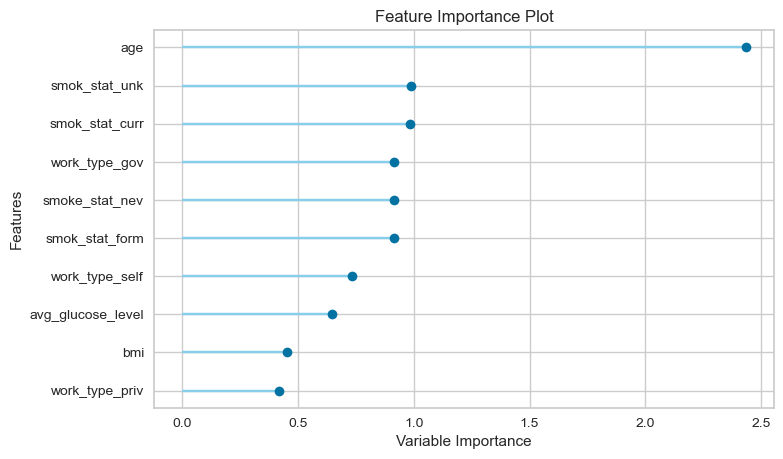

In [39]:
# Lets look at them
plot_model(pmt_model_ridge, plot='feature')

In [40]:
# Select best model
pmt_model_lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7814,0.8180,0.6000,0.1224,0.2034,0.1367,0.1959
1,0.7488,0.8195,0.7000,0.1207,0.2059,0.1374,0.2141
2,0.7116,0.7483,0.6000,0.0938,0.1622,0.0889,0.1460
3,0.8233,0.8483,0.7000,0.1667,0.2692,0.2099,0.2811
4,0.7488,0.8532,0.7000,0.1207,0.2059,0.1374,0.2141
5,0.7628,0.7590,0.7000,0.1273,0.2154,0.1483,0.2248
6,0.7243,0.7985,0.8000,0.1231,0.2133,0.1440,0.2389
7,0.8318,0.9319,1.0000,0.2174,0.3571,0.3037,0.4231
8,0.8037,0.8338,0.7000,0.1522,0.2500,0.1876,0.2614
9,0.7897,0.6451,0.4000,0.0930,0.1509,0.0813,0.1100


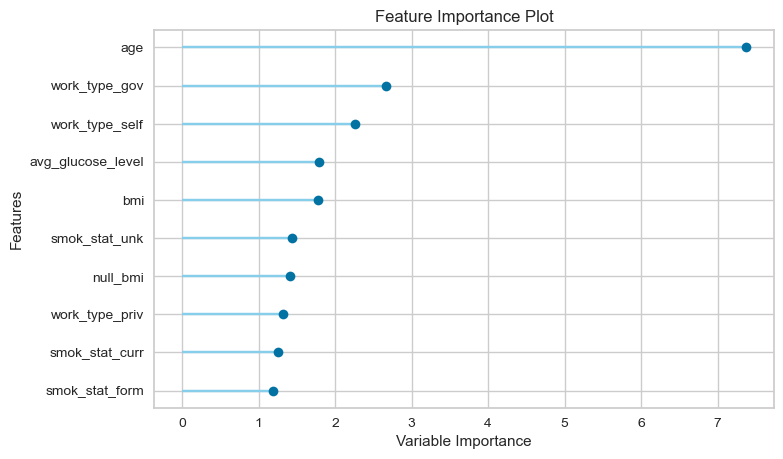

In [41]:
# Lets look at them
plot_model(pmt_model_lr, plot='feature')

In [42]:
# Select best model
pmt_model_nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4186,0.8107,0.9000,0.0677,0.1259,0.0431,0.1280
1,0.3814,0.7044,0.9000,0.0638,0.1192,0.0354,0.1135
2,0.4047,0.7810,1.0000,0.0725,0.1351,0.0530,0.1650
3,0.3674,0.8132,0.9000,0.0625,0.1169,0.0327,0.1081
4,0.3628,0.8698,1.0000,0.0680,0.1274,0.0441,0.1502
5,0.3535,0.7168,0.8000,0.0552,0.1032,0.0177,0.0592
6,0.3318,0.9324,1.0000,0.0654,0.1227,0.0383,0.1398
7,0.3972,0.9059,1.0000,0.0719,0.1342,0.0515,0.1626
8,0.3785,0.6775,0.8000,0.0576,0.1074,0.0221,0.0698
9,0.3832,0.6863,0.8000,0.0580,0.1081,0.0230,0.0718


In [43]:
# Creating a boosted ensemble model
boosted_pmt_model_nb = ensemble_model(pmt_model_nb, method = "Boosting")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8791,0.6634,0.1000,0.0556,0.0714,0.0124,0.0130
1,0.9535,0.6307,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9535,0.7810,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9116,0.6000,0.1000,0.0909,0.0952,0.0489,0.0490
4,0.9535,0.5185,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9535,0.7293,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8692,0.6020,0.1000,0.0500,0.0667,0.0047,0.0050
7,0.9533,0.9137,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8879,0.6525,0.2000,0.1111,0.1429,0.0881,0.0924
9,0.9486,0.6931,0.0000,0.0000,0.0000,-0.0086,-0.0152


In [44]:
# Creating a bagging ensemble model
bagged_pmt_model_ridge = ensemble_model(pmt_model_ridge)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7581,0.7273,0.6000,0.1111,0.1875,0.1183,0.1777
1,0.7442,0.7607,0.7000,0.1186,0.2029,0.1340,0.2106
2,0.7116,0.6946,0.7000,0.1061,0.1842,0.1125,0.1882
3,0.8047,0.8080,0.8000,0.1667,0.2759,0.2155,0.3059
4,0.7535,0.7656,0.8000,0.1356,0.2319,0.1655,0.2601
5,0.7581,0.7168,0.7000,0.1250,0.2121,0.1446,0.2212
6,0.7103,0.8115,0.9000,0.1286,0.2250,0.1560,0.2704
7,0.7897,0.8978,0.9000,0.1698,0.2857,0.2248,0.3346
8,0.7944,0.7963,0.8000,0.1600,0.2667,0.2047,0.2963
9,0.7617,0.5752,0.4000,0.0816,0.1356,0.0629,0.0901


In [45]:
# Creating a boosted ensemble model
boosted_pmt_model_lr = ensemble_model(pmt_model_lr, method = "Boosting")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7116,0.7498,0.6000,0.0938,0.1622,0.0889,0.1460
1,0.6837,0.7498,0.8000,0.1081,0.1905,0.1182,0.2119
2,0.6698,0.7678,0.8000,0.1039,0.1839,0.1107,0.2035
3,0.6605,0.8356,0.8000,0.1013,0.1798,0.1060,0.1982
4,0.6605,0.8537,1.0000,0.1205,0.2151,0.1440,0.2785
5,0.6977,0.7044,0.7000,0.1014,0.1772,0.1045,0.1793
6,0.6121,0.7833,0.7000,0.0805,0.1443,0.0660,0.1323
7,0.6869,0.8480,0.8000,0.1096,0.1928,0.1205,0.2143
8,0.6963,0.7172,0.7000,0.1014,0.1772,0.1041,0.1788
9,0.6729,0.7103,0.5000,0.0714,0.1250,0.0471,0.0816


In [46]:
# Blending estimators
blender_pmt_model = blend_models(estimator_list = [boosted_pmt_model_lr,                                                     
                                                   bagged_pmt_model_ridge,
                                                   boosted_pmt_model_nb
                                                  ], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7767,0.7732,0.6000,0.1200,0.2000,0.1328,0.1921
1,0.7628,0.7683,0.8000,0.1404,0.2388,0.1734,0.2676
2,0.7302,0.7654,0.6000,0.1000,0.1714,0.0996,0.1580
3,0.8558,0.8668,0.7000,0.2000,0.3111,0.2574,0.3214
4,0.7767,0.8673,0.7000,0.1346,0.2258,0.1603,0.2363
5,0.7953,0.7659,0.6000,0.1304,0.2143,0.1493,0.2079
6,0.7383,0.8966,0.8000,0.1290,0.2222,0.1542,0.2491
7,0.8318,0.9162,0.8000,0.1905,0.3077,0.2512,0.3366
8,0.8224,0.8324,0.6000,0.1500,0.2400,0.1786,0.2346
9,0.7897,0.6623,0.4000,0.0930,0.1509,0.0813,0.1100


In [47]:
# Tune it 
tuned_blender_model = tune_model(blender_pmt_model, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7581,0.8273,0.6000,0.1111,0.1875,0.1183,0.1777
1,0.7488,0.8068,0.7000,0.1207,0.2059,0.1374,0.2141
2,0.7023,0.7620,0.6000,0.0909,0.1579,0.0839,0.1403
3,0.8140,0.7820,0.8000,0.1739,0.2857,0.2266,0.3156
4,0.7442,0.8678,0.7000,0.1186,0.2029,0.1340,0.2106
5,0.7628,0.7688,0.7000,0.1273,0.2154,0.1483,0.2248
6,0.7290,0.8225,0.9000,0.1364,0.2368,0.1694,0.2836
7,0.7944,0.9108,0.9000,0.1731,0.2903,0.2300,0.3392
8,0.8084,0.8206,0.7000,0.1556,0.2545,0.1928,0.2661
9,0.7617,0.6814,0.4000,0.0816,0.1356,0.0629,0.0901


In [48]:
# Finalize the model
final_pmt_model = finalize_model(tuned_blender_model)

## Validation Data

In [49]:
# predict validation data
val_predictions = predict_model(final_pmt_model, data=X_val)
val_predictions.Label

4673    0
3232    1
3694    0
1070    1
4163    0
       ..
47      0
2327    1
2119    0
4435    0
1929    0
Name: Label, Length: 2044, dtype: int32

In [50]:
# Check stats
print(classification_report(y_val, val_predictions.Label))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1938
           1       0.16      0.75      0.26       106

    accuracy                           0.78      2044
   macro avg       0.57      0.76      0.57      2044
weighted avg       0.94      0.78      0.84      2044



[Text(0, 0.5, 'None'), Text(0, 1.5, 'Stroke')]

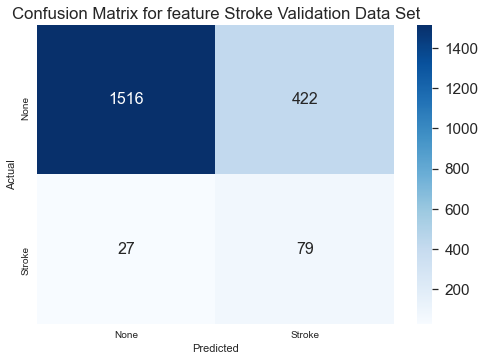

<Figure size 720x504 with 0 Axes>

In [51]:
# Draw confusion matrix 
data = confusion_matrix(y_val, val_predictions.Label)
ax= plt.subplot()

df_cm = pd.DataFrame(data, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,ax = ax, annot_kws={"size": 16},fmt='d')# font size
ax.set_title('Confusion Matrix for feature Stroke Validation Data Set') 
ax.xaxis.set_ticklabels(['None', 'Stroke'])   
ax.yaxis.set_ticklabels(['None', 'Stroke'])

In [52]:
# Gather metrics 
auc = metrics.roc_auc_score(y_val, val_predictions.Label)
auc = round(auc,2)
print('AUC: %.2f' % auc)

AUC: 0.76


In [53]:
# Save the model as a pickle file
filename = 'pickle/stroke_model.pickle'
pickle.dump(final_pmt_model, open(filename, 'wb'))

In [54]:
save_model(final_pmt_model, 'stroke_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='stroke',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                                                         warm_start=False)),
                                                      ('ada_1',
                                                       AdaBoostClassifier(algorithm='SAMME.R',
                      